# Detection of Pneumonia in X-Ray Images (Pneumonia vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 50 kB 6.3 MB/s 


##### Import libraries

In [4]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Download dataset

###### *Chest X-Ray Images (Pneumonia)*  
[Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
[Paper](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)
[Data](https://data.mendeley.com/datasets/rscbjbr9sj/2)


In [5]:
# problem: also 'small' part of the normal images in the used covid dataset
if not os.path.exists('chest_xray'):
    !wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded -O ChestXRay2017.zip
    !unzip -q ChestXRay2017.zip
    !rm ChestXRay2017.zip
    !rm -r __MACOSX
    !rm chest_xray/train/PNEUMONIA/.DS_Store

--2021-10-21 07:47:05--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2021-10-21 07:47:06--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.105.51
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.105.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applicat

##### Define constants

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [224, 224, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [7]:
savepath = 'data'

## dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# path to normal 
normal_imgpaths = ['chest_xray/train/NORMAL', 'chest_xray/test/NORMAL']

# path to pneumonia 
pneumonia_imgpaths = ['chest_xray/train/PNEUMONIA', 'chest_xray/test/PNEUMONIA']

In [8]:
# stats
normal_cnt = sum([len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) for path in normal_imgpaths])
pneumonia_cnt = sum([len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) for path in pneumonia_imgpaths])

class_count = {'normal': normal_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + pneumonia_cnt)

Class count:  {'normal': 1583, 'pneumonia': 4273}
Total images:  5856


### Load dataset

###### Retrieve filenames (paths) and labels

In [9]:
def get_data(paths, label_encoding):
    normal_imgpaths, pneumonia_imgpaths = paths
    filenames = []
    y_labels = []

    # nomal
    nomal_images = []
    for nomal_imgpath in normal_imgpaths:
        nomal_images.extend([nomal_imgpath + '/' + name for name in os.listdir(nomal_imgpath) if os.path.isfile(os.path.join(nomal_imgpath, name))])
    random.shuffle(nomal_images)
    nomal_images = nomal_images[:int(len(nomal_images))]
    filenames.extend(nomal_images)
    y_labels.extend([label_encoding.index('normal') for img in nomal_images])

    # pneumonia
    pneumonia_images = []
    for pneumonia_imgpath in pneumonia_imgpaths:
        pneumonia_images.extend([pneumonia_imgpath + '/' + name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])
    random.shuffle(pneumonia_images)
    pneumonia_images = pneumonia_images[:int(IMBALANCE_RATIO*len(nomal_images))]
    filenames.extend(pneumonia_images)
    y_labels.extend([label_encoding.index('pneumonia') for img in pneumonia_images])

    return np.array(filenames), np.array(y_labels)

In [10]:
datapaths = [normal_imgpaths, pneumonia_imgpaths]
label_encoding = ['normal', 'pneumonia'] # normal = 0, pneumonia = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [11]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [12]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 3165, Val: 198, Test: 594


In [13]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'pneumonia': np.count_nonzero(y == 1)}

In [14]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 1246, 'pneumonia': 1919}
val set:  {'normal': 74, 'pneumonia': 124}
test set:   {'normal': 263, 'pneumonia': 331}


###### Create tensors

In [15]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [16]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [17]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [18]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [19]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [20]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [21]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [22]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [23]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

### Visualization

###### Distribution of labels in the sets

In [24]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

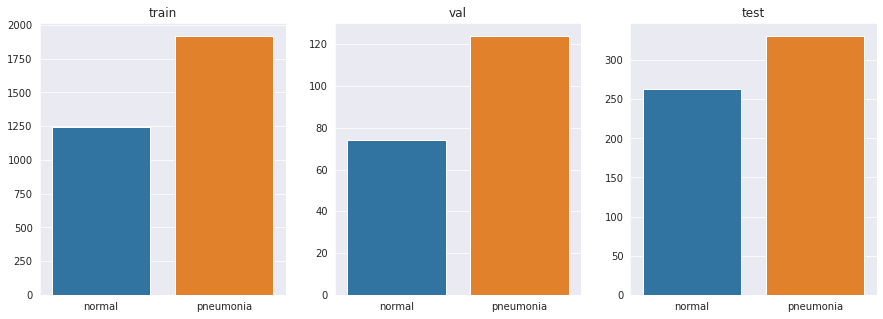

In [25]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [26]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("PNEUMONIA")
        plt.axis("off")

In [27]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


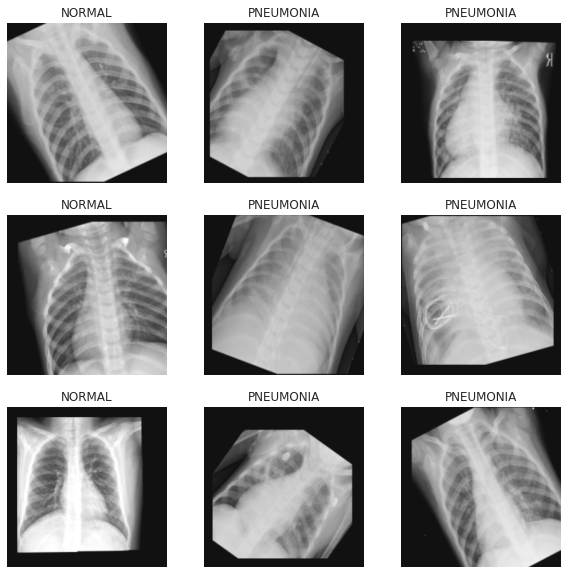

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [29]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for pneumonia: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	1.27
Weight for pneumonia: 	0.82


### Learning rate decay

In [30]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## Shallow Network
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [31]:
def shallow_builder(weights=False, dropout=False, bn=False, activation='relu', name='ShallowNetwork'):

    seq = [InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]), name='Input'),]
    seq.append(Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation=activation, name='Conv1'))
    if bn:
        seq.append(BatchNormalization(name='BN1'))
    seq.append(MaxPooling2D(pool_size=(2,2), name='Pool1'))
    seq.append(Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation=activation, name='Conv2'))
    if bn:
        seq.append(BatchNormalization(name='BN2'))
    seq.append(MaxPooling2D(pool_size=(2,2), name='Pool2'))
    seq.append(Flatten(name='Flatten'))
    seq.append(Dense(units=32, activation=activation, name='Dense'))
    if bn:
        seq.append(BatchNormalization(name='BN3'))
    if dropout:
        seq.append(Dropout(rate=dropout), name='Dropout')
    seq.append(Dense(units=1, activation='sigmoid', name='Output'))

    model = Sequential(seq, name=name)

    # load weights from pneumonia pretraining
    if weights == 'pneumonia' and activation == 'relu':
        model.load_weights(weights_path+'shallow_relu_public_weights.h5', by_name=True)
    if weights == 'pneumonia' and activation == 'tanh':
        model.load_weights(weights_path+'shallow_tanh_public_weights.h5', by_name=True)
    
    return model

In [32]:
shallow = shallow_builder(bn=True, name='ShallowNetwork-bn')

models = [
    shallow,
]

METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]


shallow.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

Model: "ShallowNetwork-bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 109, 109, 16)      3088      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 109, 109, 16)      64        
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 54, 54, 16)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 26, 26, 32)        8224      
_________________________________________________________________
BN2 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 13, 13, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 5408)        

In [33]:
shallow.summary()

Model: "ShallowNetwork-bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 109, 109, 16)      3088      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 109, 109, 16)      64        
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 54, 54, 16)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 26, 26, 32)        8224      
_________________________________________________________________
BN2 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 13, 13, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 5408)        

### Training

In [34]:
history_shallow = shallow.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
98/98 [==============================] - 230s 2s/step - loss: 0.3665 - accuracy: 0.8415 - precision: 0.9215 - recall: 0.8077 - val_loss: 0.8776 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 2/20
98/98 [==============================] - 170s 2s/step - loss: 0.3092 - accuracy: 0.8728 - precision: 0.9301 - recall: 0.8542 - val_loss: 1.3430 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 3/20
98/98 [==============================] - 143s 1s/step - loss: 0.2947 - accuracy: 0.8849 - precision: 0.9348 - recall: 0.8702 - val_loss: 1.5719 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 4/20
98/98 [==============================] - 144s 1s/step - loss: 0.2711 - accuracy: 0.8852 - precision: 0.9383 - recall: 0.8685 - val_loss: 1.9705 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 5/20
98/98 [==============================] - 145s 1s/step - loss: 0.2534 - accuracy: 0.8909 - precisi

### Evaluation

###### Predict on test set

In [35]:
loss, acc, prec, rec = shallow.evaluate(test_batched)

19/19 [==============================] - 5s 255ms/step - loss: 0.2631 - accuracy: 0.8939 - precision: 0.9718 - recall: 0.8338


###### Save for transfer learning

In [36]:
# save weights
path = 'shallow_relu_public_weights.h5'
if not os.path.exists(weights_path+path):
    shallow.save_weights(weights_path+path)